# Importing the libraries

In [1]:
import pandas as pd
import re
import pickle
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from tensorflow.keras.layers import TextVectorization
import string
from nltk.tokenize import word_tokenize

# Download NLTK resources (stopwords and WordNet)
import nltk

nltk.download("stopwords")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ropar_i9941t3\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
# Shuffle and batch the dataset
batch_size = 32
seed = 42

# Vocabulary size and number of words in a sequence
vocab_size = 10000
sequence_length = 100

stop_words = tf.constant(stopwords.words("english"))

In [12]:
with open("../Artifacts/stop_words.pkl", "wb") as f:
    pickle.dump(stop_words, f)

# Exploratory data analysis

In [5]:
df = pd.read_csv("../Dataset/Job_text_features.csv")
df.drop(["Unnamed: 0"], inplace=True, axis=1)
df.head(5)

,description,requirements,benefits,fraudulent
0,"Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0
1,Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0
2,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0
3,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0
4,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0


In [6]:
# Checking percentage of missinng values
df.isnull().mean() * 100

description      0.005682
requirements    15.051992
benefits        40.388658
fraudulent       0.000000
dtype: float64

In [14]:
df.iloc[1].description

"Organised - Focused - Vibrant - Awesome!Do you have a passion for customer service? Slick typing skills? Maybe Account Management? ...And think administration is cooler than a polar bear on a jetski? Then we need to hear you!\xa0We are the Cloud Video Production Service and opperating on a glodal level. Yeah, it's pretty cool. Serious about\xa0delivering a world class product and excellent customer service.Our rapidly expanding business is looking for a talented Project Manager to manage the successful delivery of video projects, manage client communications and drive the production process. Work with some of the coolest brands on the planet and learn from a global team that are representing NZ is a huge way!We are entering the next growth stage of our business and growing quickly internationally. \xa0Therefore, the position is bursting with opportunity for the right person entering the business at the right time.\xa090 Seconds, the worlds Cloud Video Production Service -\xa0http://90

In [6]:
# Removing the missing values
df.dropna(inplace=True)

In [7]:
# Checking if there are any duplicate values
duplicate_counts = df.duplicated().sum()
if duplicate_counts > 0:

    # Storing all the duplicate data
    Duplicate_df = df[df.duplicated() == True]
    print(
        "Duplicate values found and stored in dataframe, dataframe size : ",
        Duplicate_df.shape[0],
    )
else:
    print("There are no duplicate values")

Duplicate values found and stored in dataframe, dataframe size :  1430


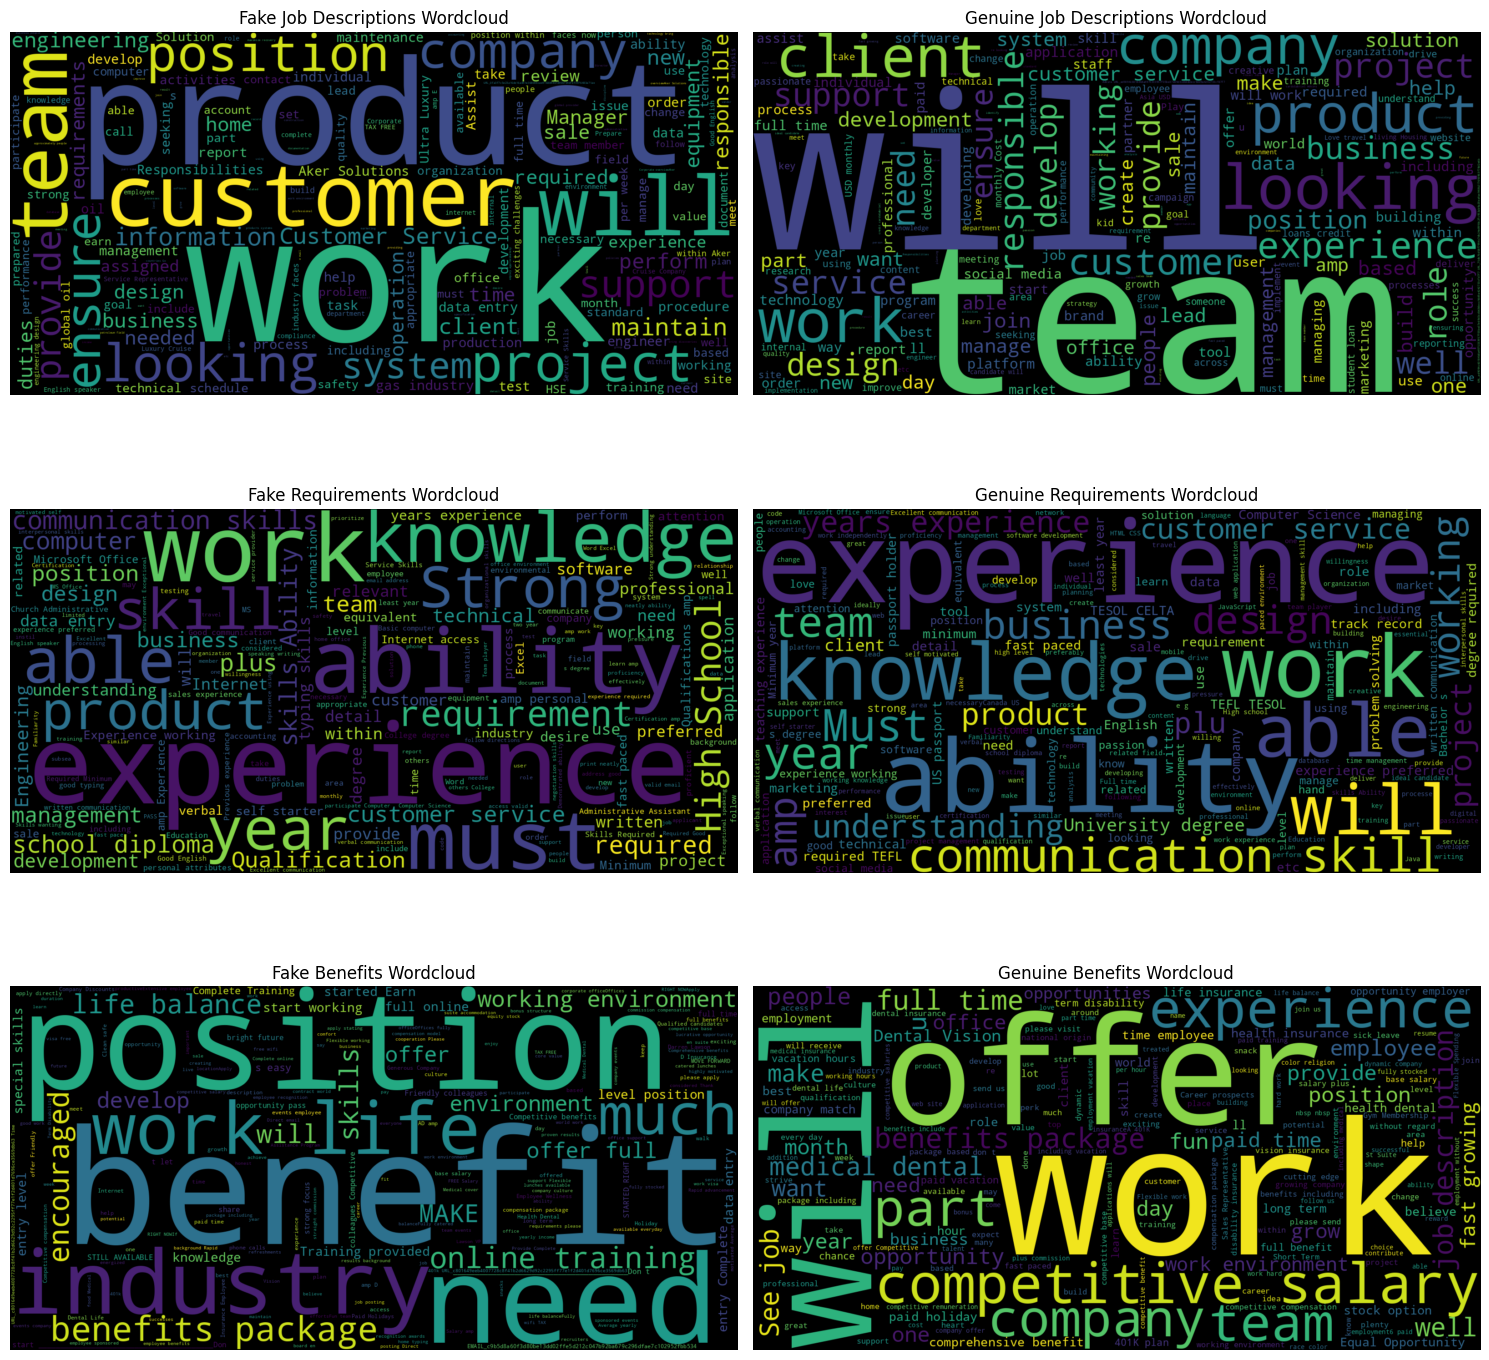

In [8]:
# Extracting the course titles and joining sentences into a single string
fake_jd = df[df["fraudulent"] == 1]["description"].values
genuine_jd = df[df["fraudulent"] == 0]["description"].values

fake_req = df[df["fraudulent"] == 1]["requirements"].values
genuine_req = df[df["fraudulent"] == 0]["requirements"].values

fake_benefits = df[df["fraudulent"] == 1]["benefits"].values
genuine_benefits = df[df["fraudulent"] == 0]["benefits"].values

# Joining all job descriptions, requirements, and benefits into single strings
fake_jd_string = " ".join(fake_jd.tolist())
genuine_jd_string = " ".join(genuine_jd.tolist())

fake_req_string = " ".join(fake_req.tolist())
genuine_req_string = " ".join(genuine_req.tolist())

fake_benefits_string = " ".join(fake_benefits.tolist())
genuine_benefits_string = " ".join(genuine_benefits.tolist())

# Set other parameters for word clouds
wordcloud1 = WordCloud(width=1600, height=800).generate(fake_jd_string)
wordcloud2 = WordCloud(width=1600, height=800).generate(genuine_jd_string)
wordcloud3 = WordCloud(width=1600, height=800).generate(fake_req_string)
wordcloud4 = WordCloud(width=1600, height=800).generate(genuine_req_string)
wordcloud5 = WordCloud(width=1600, height=800).generate(fake_benefits_string)
wordcloud6 = WordCloud(width=1600, height=800).generate(genuine_benefits_string)

# Plotting
fig, ax = plt.subplots(3, 2, figsize=(15, 15))

ax[0, 0].imshow(wordcloud1, interpolation="bilinear")
ax[0, 0].set_title("Fake Job Descriptions Wordcloud")
ax[0, 0].axis("off")

ax[0, 1].imshow(wordcloud2, interpolation="bilinear")
ax[0, 1].set_title("Genuine Job Descriptions Wordcloud")
ax[0, 1].axis("off")

ax[1, 0].imshow(wordcloud3, interpolation="bilinear")
ax[1, 0].set_title("Fake Requirements Wordcloud")
ax[1, 0].axis("off")

ax[1, 1].imshow(wordcloud4, interpolation="bilinear")
ax[1, 1].set_title("Genuine Requirements Wordcloud")
ax[1, 1].axis("off")

ax[2, 0].imshow(wordcloud5, interpolation="bilinear")
ax[2, 0].set_title("Fake Benefits Wordcloud")
ax[2, 0].axis("off")

ax[2, 1].imshow(wordcloud6, interpolation="bilinear")
ax[2, 1].set_title("Genuine Benefits Wordcloud")
ax[2, 1].axis("off")

plt.tight_layout()
plt.show()

In [9]:
text_data_combined = df["description"] + " " + df["requirements"] + " " + df["benefits"]
target_data = df["fraudulent"].values

# Create a dataset from the input text features and target output data
raw_text_ds = tf.data.Dataset.from_tensor_slices((text_data_combined, target_data))

# Shuffling the items
seed = 42
raw_text_ds = raw_text_ds.shuffle(len(df), seed=seed)

In [10]:
count = 1
for text, label in raw_text_ds:
    if count <= 3:
        print("TEXT" + str(count) + ":", text)
        count = count + 1
    else:
        break

TEXT1: tf.Tensor(b'Title: Field Sales RepresentativeLocation: San Antonio, TX \xe2\x80\x93 Work from HomeTerritory: Greater San AntonioCompensation: Base Salary + Commission*Benefits Included Veterans Home Care of Texas, #URL_5d4f37febf1875b6f624f67a5f859a46dc98ef8f26bfbab9e31ed#PHONE_f709f5c5d679b0722df63a17d00b2c23733b0b0ca00280a7889fd815e40da83f##, is a growing company that provides and manages at-home personal care for veterans or their surviving spouses. SpotSource Solutions is the Exclusive Recruiting Agency for these positions and is now accepting resumes for an Account Executive position located in San Antonio, Texas.The ideal candidate must enjoy interacting with seniors and have a patient and professional demeanor. A qualified candidate is someone looking to build on their inside sales and account management skills in a position that requires attention to detail, strong time management, and excellent communication skills. Honesty, compassion and self-motivation are required f

In [12]:
count = 1
for text, label in raw_text_ds:
    if count <= 5:
        print("Label " + str(count) + ":", label)
        count = count + 1
    else:
        break

Label 1: tf.Tensor(0, shape=(), dtype=int64)
Label 2: tf.Tensor(0, shape=(), dtype=int64)
Label 3: tf.Tensor(0, shape=(), dtype=int64)
Label 4: tf.Tensor(0, shape=(), dtype=int64)
Label 5: tf.Tensor(0, shape=(), dtype=int64)


In [13]:
# Remove stop words
def remove_stopwords(token):
    return tf.math.logical_not(tf.reduce_any(tf.math.equal(stop_words, token)))

In [14]:
def process_text(input_data):
    """
    Output: Cleaned text tensor

    Description: This function will take a single raw text as input, remove all stopwords and punctuation, then lowercase the words to eliminate any ambiguity.
    Ultimately clean text will be returned as a tensor.
    """

    # Lowercase the input data
    lowercase = tf.strings.lower(input_data)

    # Remove punctuation
    no_punctuation = tf.strings.regex_replace(
        lowercase, "[%s]" % re.escape(string.punctuation), ""
    )

    # Tokenizing the words in the strings
    tokens = tf.strings.split(no_punctuation)

    filtered_tokens = tf.map_fn(remove_stopwords, tokens, fn_output_signature=tf.bool)

    # Filter tokens based on the boolean mask
    filtered_tokens = tf.boolean_mask(tokens, filtered_tokens)

    processed_text = tf.strings.reduce_join(filtered_tokens, separator=" ", axis=-1)
    return processed_text

In [15]:
# Cleaning all the texts
clean_train_ds = raw_text_ds.map(lambda x, y: (process_text(x), y))

In [16]:
print("Total strings : ", len(raw_text_ds))
print("Total Training strings (80:20) : ", int(len(raw_text_ds) * 0.8))
print("Total Testing strings : ", int(len(raw_text_ds) * 0.2))

Total strings :  10224
Total Training strings (80:20) :  8179
Total Testing strings :  2044


In [17]:
def create_train_test_val(ds, train_size, val_size):

    # Creating batch and also Calculating total batches
    ds = ds.batch(batch_size)
    total_batches = len(ds)

    # Extracting training,testing and validation batch from the dataset (ds)
    train_ds_batches = int(train_size * total_batches)
    test_ds_batches = int(val_size * total_batches)

    # 80:20
    train_ds = ds.take(train_ds_batches)
    test_ds = ds.skip(train_ds_batches).take(test_ds_batches)

    # Catching and prefetching the dataset to improve data pipeline performance
    train_ds = train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
    test_ds = test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

    return train_ds, test_ds


# Calling the function
train_ds, test_ds = create_train_test_val(raw_text_ds, 0.8, 0.2)

In [18]:
# Display some benchmark statistics
tfds.benchmark(train_ds)


************ Summary ************



  0%|          | 0/256 [00:00<?, ?it/s]

Examples/sec (First included) 2443.90 ex/sec (total: 257 ex, 0.11 sec)
Examples/sec (First only) 28.04 ex/sec (total: 1 ex, 0.04 sec)
Examples/sec (First excluded) 3683.96 ex/sec (total: 256 ex, 0.07 sec)


,duration,num_examples,avg
first+lasts,0.10516,257,2443.896900
first,0.03567,1,28.035103
lasts,0.06949,256,3683.964699


In [19]:
# Display some benchmark statistics
tfds.benchmark(test_ds)


************ Summary ************



  0%|          | 0/64 [00:00<?, ?it/s]

Examples/sec (First included) 966.78 ex/sec (total: 65 ex, 0.07 sec)
Examples/sec (First only) 21.89 ex/sec (total: 1 ex, 0.05 sec)
Examples/sec (First excluded) 2970.43 ex/sec (total: 64 ex, 0.02 sec)


,duration,num_examples,avg
first+lasts,0.067233,65,966.784425
first,0.045688,1,21.887822
lasts,0.021546,64,2970.432638


In [20]:
# Defining the text vectorization layer
vectorize_layer = TextVectorization(
    standardize=None,
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length,
)

In [21]:
# Make a text-only dataset (no labels) and call adapt to build the vocabulary.
train_text_ds = clean_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text_ds)

In [ ]:
# Get the learned vocabulary
vocabulary = vectorize_layer.get_vocabulary()

# Print the vocabulary
print("Vocabulary:", vocabulary)

In [22]:
model = tf.keras.Sequential(
    [
        vectorize_layer,
        tf.keras.layers.Embedding(
            input_dim=len(vectorize_layer.get_vocabulary()),
            output_dim=64,
            mask_zero=True,
        ),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
        tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.Dense(1),
    ]
)

In [23]:
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(1e-4),
    metrics=["accuracy"],
)

In [24]:
history = model.fit(train_ds, epochs=30, validation_data=test_ds)

Epoch 1/30
256/256 ━━━━━━━━━━━━━━━━━━━━ 81s 286ms/step - accuracy: 0.9539 - loss: 0.4332 - val_accuracy: 0.9567 - val_loss: 0.1780
Epoch 2/30
256/256 ━━━━━━━━━━━━━━━━━━━━ 72s 282ms/step - accuracy: 0.9539 - loss: 0.1874 - val_accuracy: 0.9567 - val_loss: 0.1765
Epoch 3/30
256/256 ━━━━━━━━━━━━━━━━━━━━ 72s 281ms/step - accuracy: 0.9539 - loss: 0.1853 - val_accuracy: 0.9567 - val_loss: 0.1742
Epoch 4/30
256/256 ━━━━━━━━━━━━━━━━━━━━ 72s 281ms/step - accuracy: 0.9539 - loss: 0.1816 - val_accuracy: 0.9567 - val_loss: 0.1664
Epoch 5/30
256/256 ━━━━━━━━━━━━━━━━━━━━ 73s 284ms/step - accuracy: 0.9539 - loss: 0.1662 - val_accuracy: 0.9567 - val_loss: 0.1056
Epoch 6/30
256/256 ━━━━━━━━━━━━━━━━━━━━ 72s 281ms/step - accuracy: 0.9539 - loss: 0.1001 - val_accuracy: 0.9621 - val_loss: 0.0825
Epoch 7/30
256/256 ━━━━━━━━━━━━━━━━━━━━ 72s 282ms/step - accuracy: 0.9678 - loss: 0.0683 - val_accuracy: 0.9803 - val_loss: 0.0613
Epoch 8/30
256/256 ━━━━━━━━━━━━━━━━━━━━ 71s 278ms/step - accuracy: 0.9815 - loss: 0

In [25]:
model.save("/kaggle/working/my_model.keras")